In [1]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
house_df_org = pd.read_csv("house_train.csv")

In [6]:
house_df = house_df_org.copy()

In [7]:
print(house_df.shape)

(1460, 81)


In [8]:
print(house_df.dtypes.value_counts())

object     43
int64      35
float64     3
dtype: int64


In [9]:
isnull_series = house_df.isnull().sum()

In [10]:
print("Null", isnull_series[isnull_series > 0].sort_values(ascending=False))

Null PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


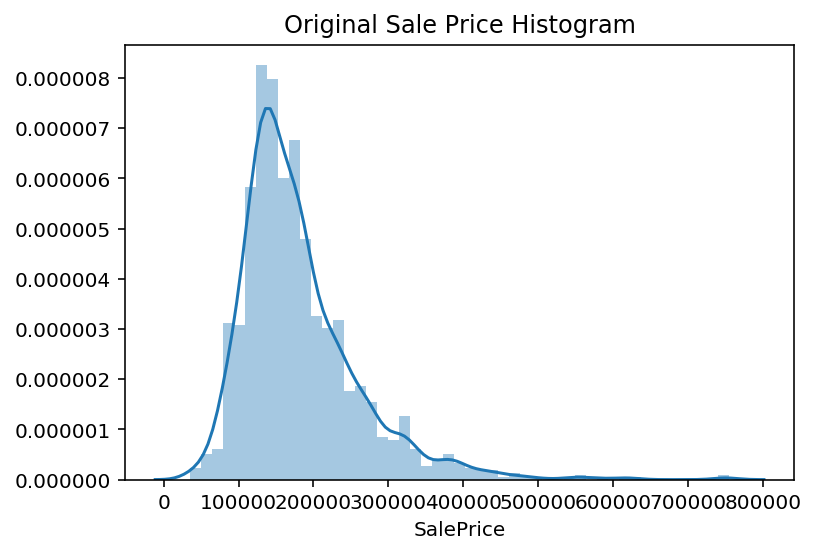

In [12]:
plt.title("Original Sale Price Histogram")
sns.distplot(house_df['SalePrice']);

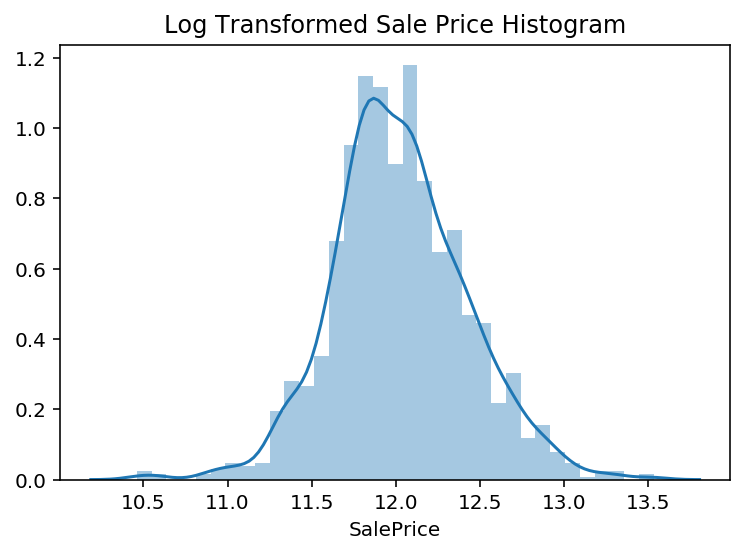

In [15]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice);

In [16]:
originalSalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [17]:
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [18]:
house_df.fillna(house_df.mean(), inplace=True)

In [20]:
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]

In [21]:
print(house_df.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [23]:
print(house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print(house_df_ohe.shape)

(1460, 75)
(1460, 271)


In [24]:
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print(house_df_ohe.dtypes[null_column_count.index])

Series([], dtype: object)


In [34]:
def get_rmse(model):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

In [28]:
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=402)

In [32]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(x_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

In [35]:
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.169
Ridge 로그 변환된 RMSE: 0.133
Lasso 로그 변환된 RMSE: 0.173


[0.16895385365506782, 0.133430994230533, 0.1726907460400906]

- 라쏘는 타 회귀보다 결과가 떨어짐

In [36]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=x_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    
    return coef_high, coef_low

In [42]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
            
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        

In [43]:
models = [lr_reg, ridge_reg, lasso_reg]

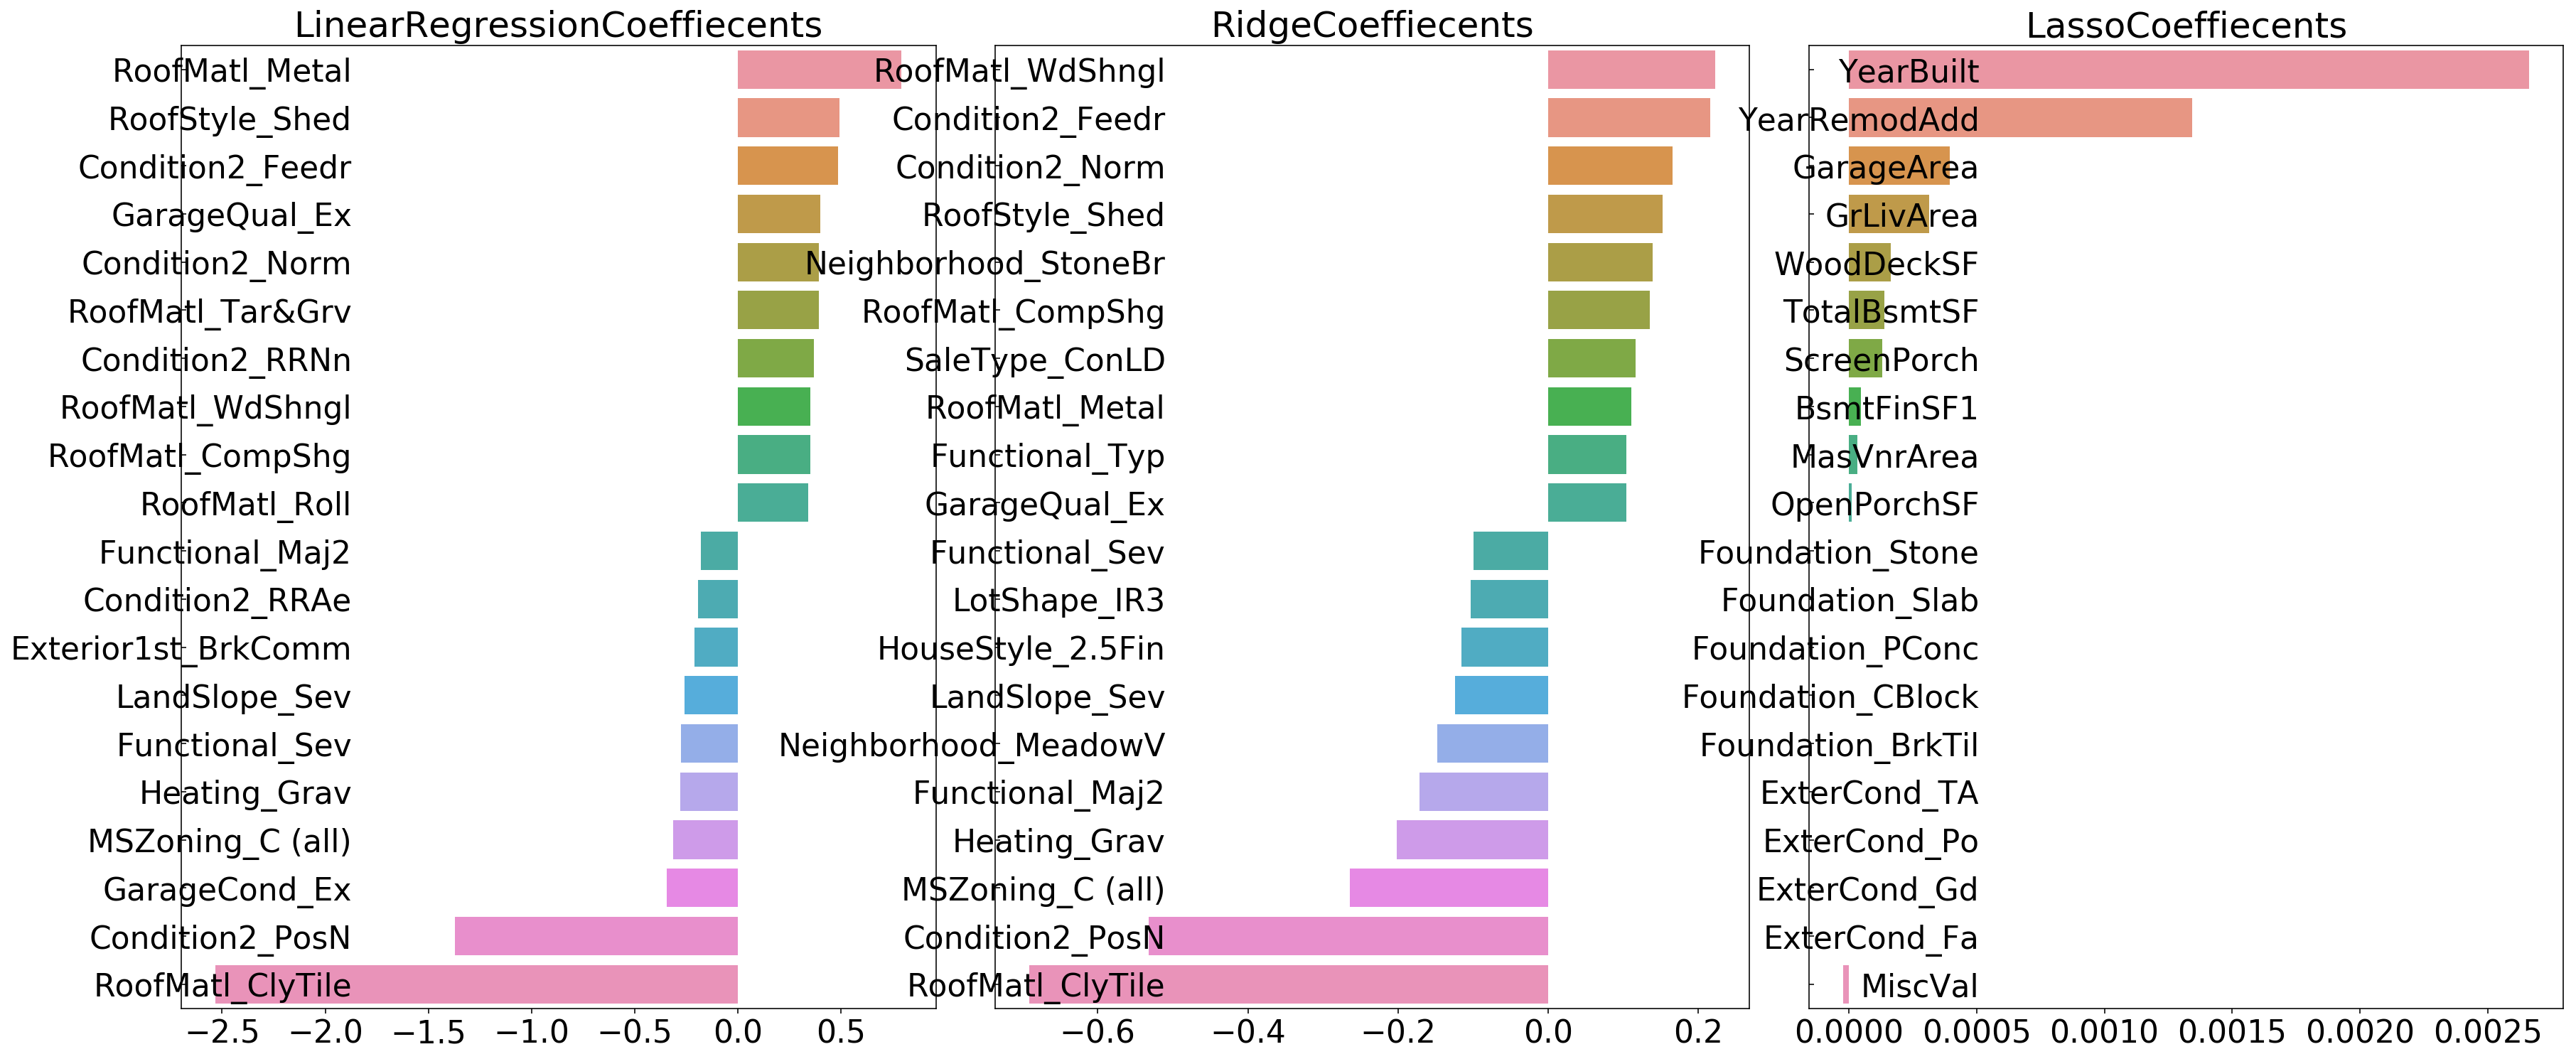

In [44]:
visualize_coefficient(models)

- Linear Regression과 Ridge는 회귀 계수가 유사함

In [46]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, x_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__}, {np.round(rmse_list, 3)}')
        print(f'{model.__class__.__name__}, {np.round(rmse_avg, 3)}')

In [47]:
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression, [0.135 0.165 0.168 0.111 0.198]
LinearRegression, 0.155
Ridge, [0.117 0.154 0.142 0.117 0.189]
Ridge, 0.144
Lasso, [0.161 0.204 0.177 0.181 0.265]
Lasso, 0.198


In [48]:
from sklearn.model_selection import GridSearchCV

In [57]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(x_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    
    print(f'{model.__class__.__name__} 5 CV시 최적 평균 RMSE 값:{np.round(rmse, 4)}, 최적 alpha : {grid_model.best_params_}')

In [58]:
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}

In [59]:
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

In [60]:
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE 값:0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV시 최적 평균 RMSE 값:0.142, 최적 alpha : {'alpha': 0.001}


In [61]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [62]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.169
Ridge 로그 변환된 RMSE: 0.123
Lasso 로그 변환된 RMSE: 0.116


[0.16895385365508267, 0.12284442326569761, 0.11609581544527836]

In [63]:
models = [lr_reg, ridge_reg, lasso_reg]

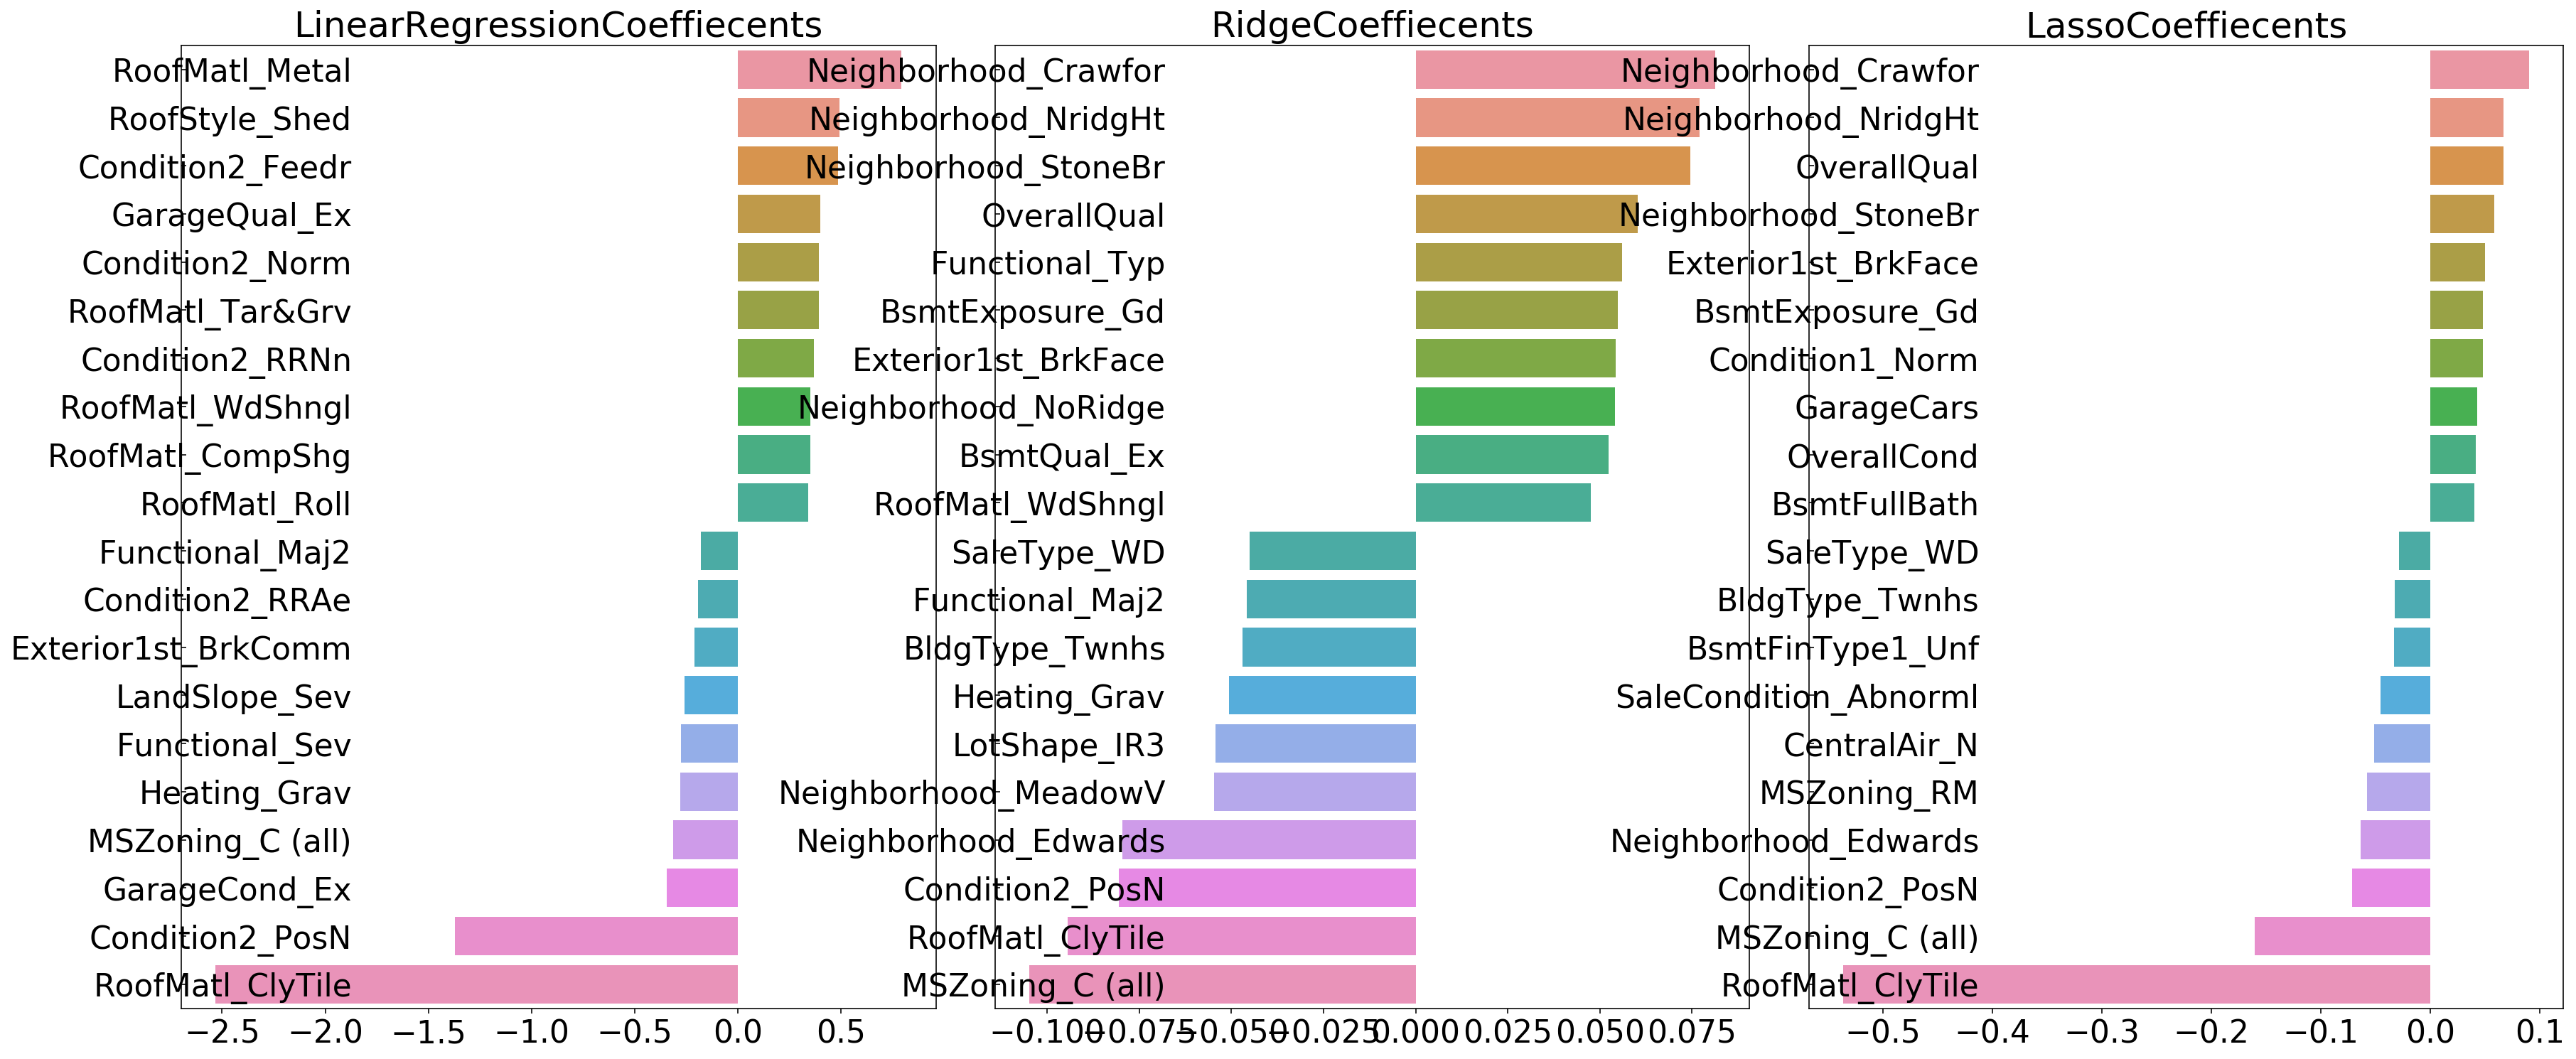

In [64]:
visualize_coefficient(models)

- 1) Feature 데이터에서 데이터 분포 확인(왜곡)
    - skew
- 2) 아웃라이어 처리

In [65]:
from scipy.stats import skew

In [66]:
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(lambda x: skew(x))

skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


- 왜곡이 높은 피처를 로그 변환

In [67]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [68]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']

In [70]:
house_df_ohe.shape

(1460, 271)

In [75]:
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(x_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


In [79]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


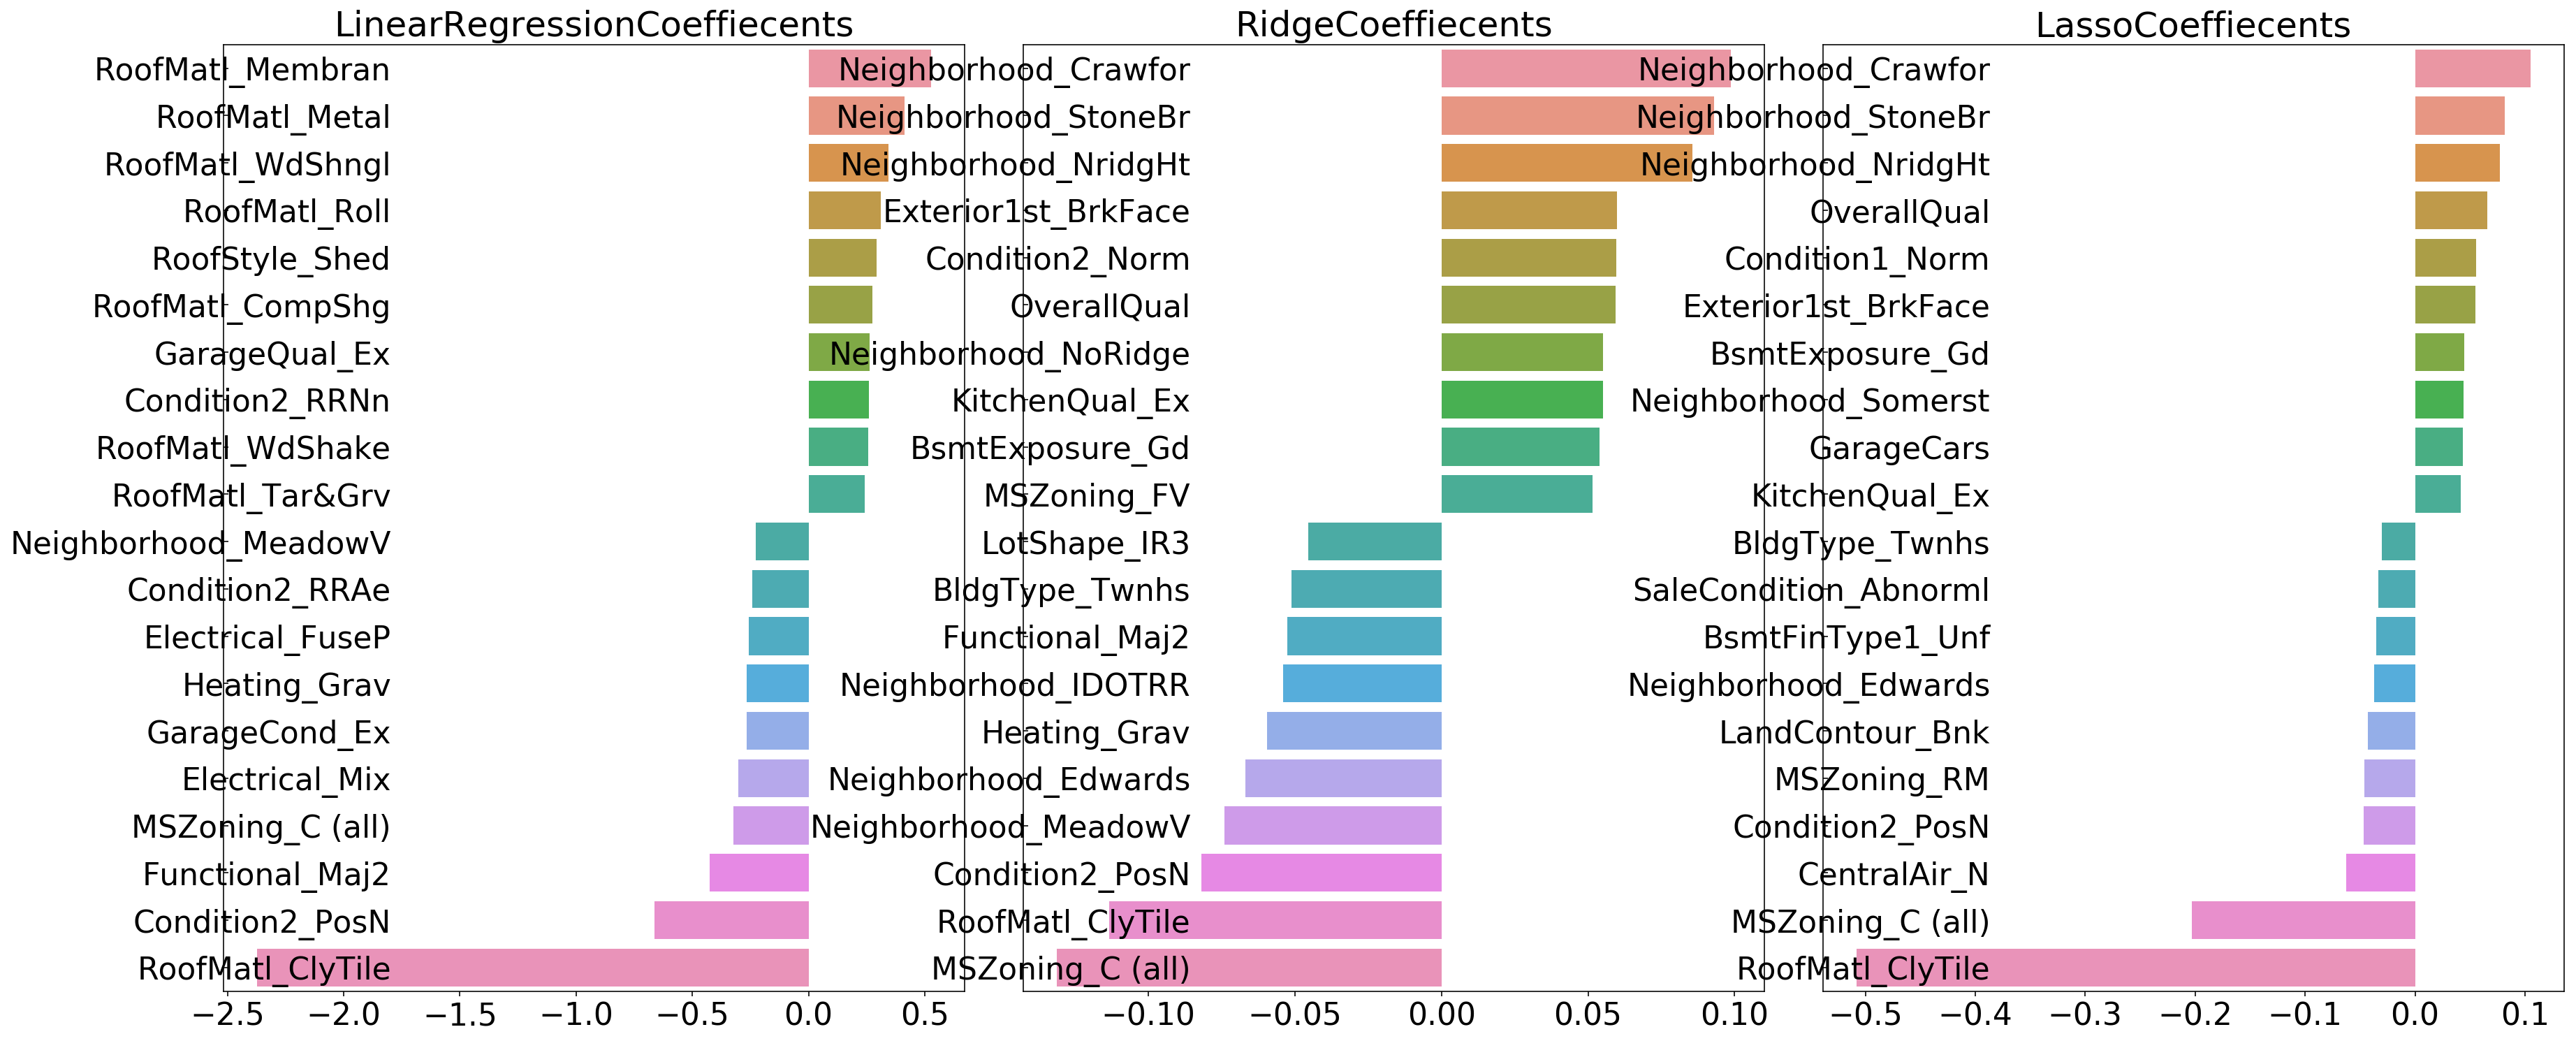

In [80]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

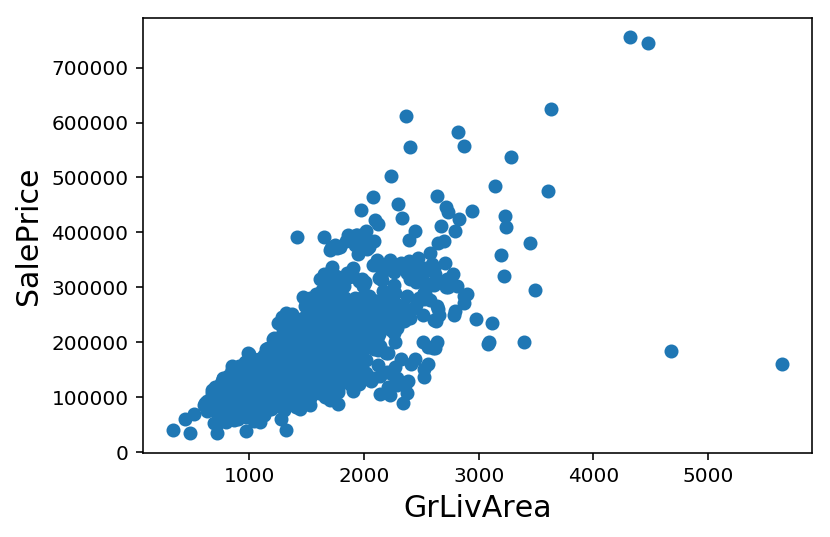

In [81]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [82]:

cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)


house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [84]:
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


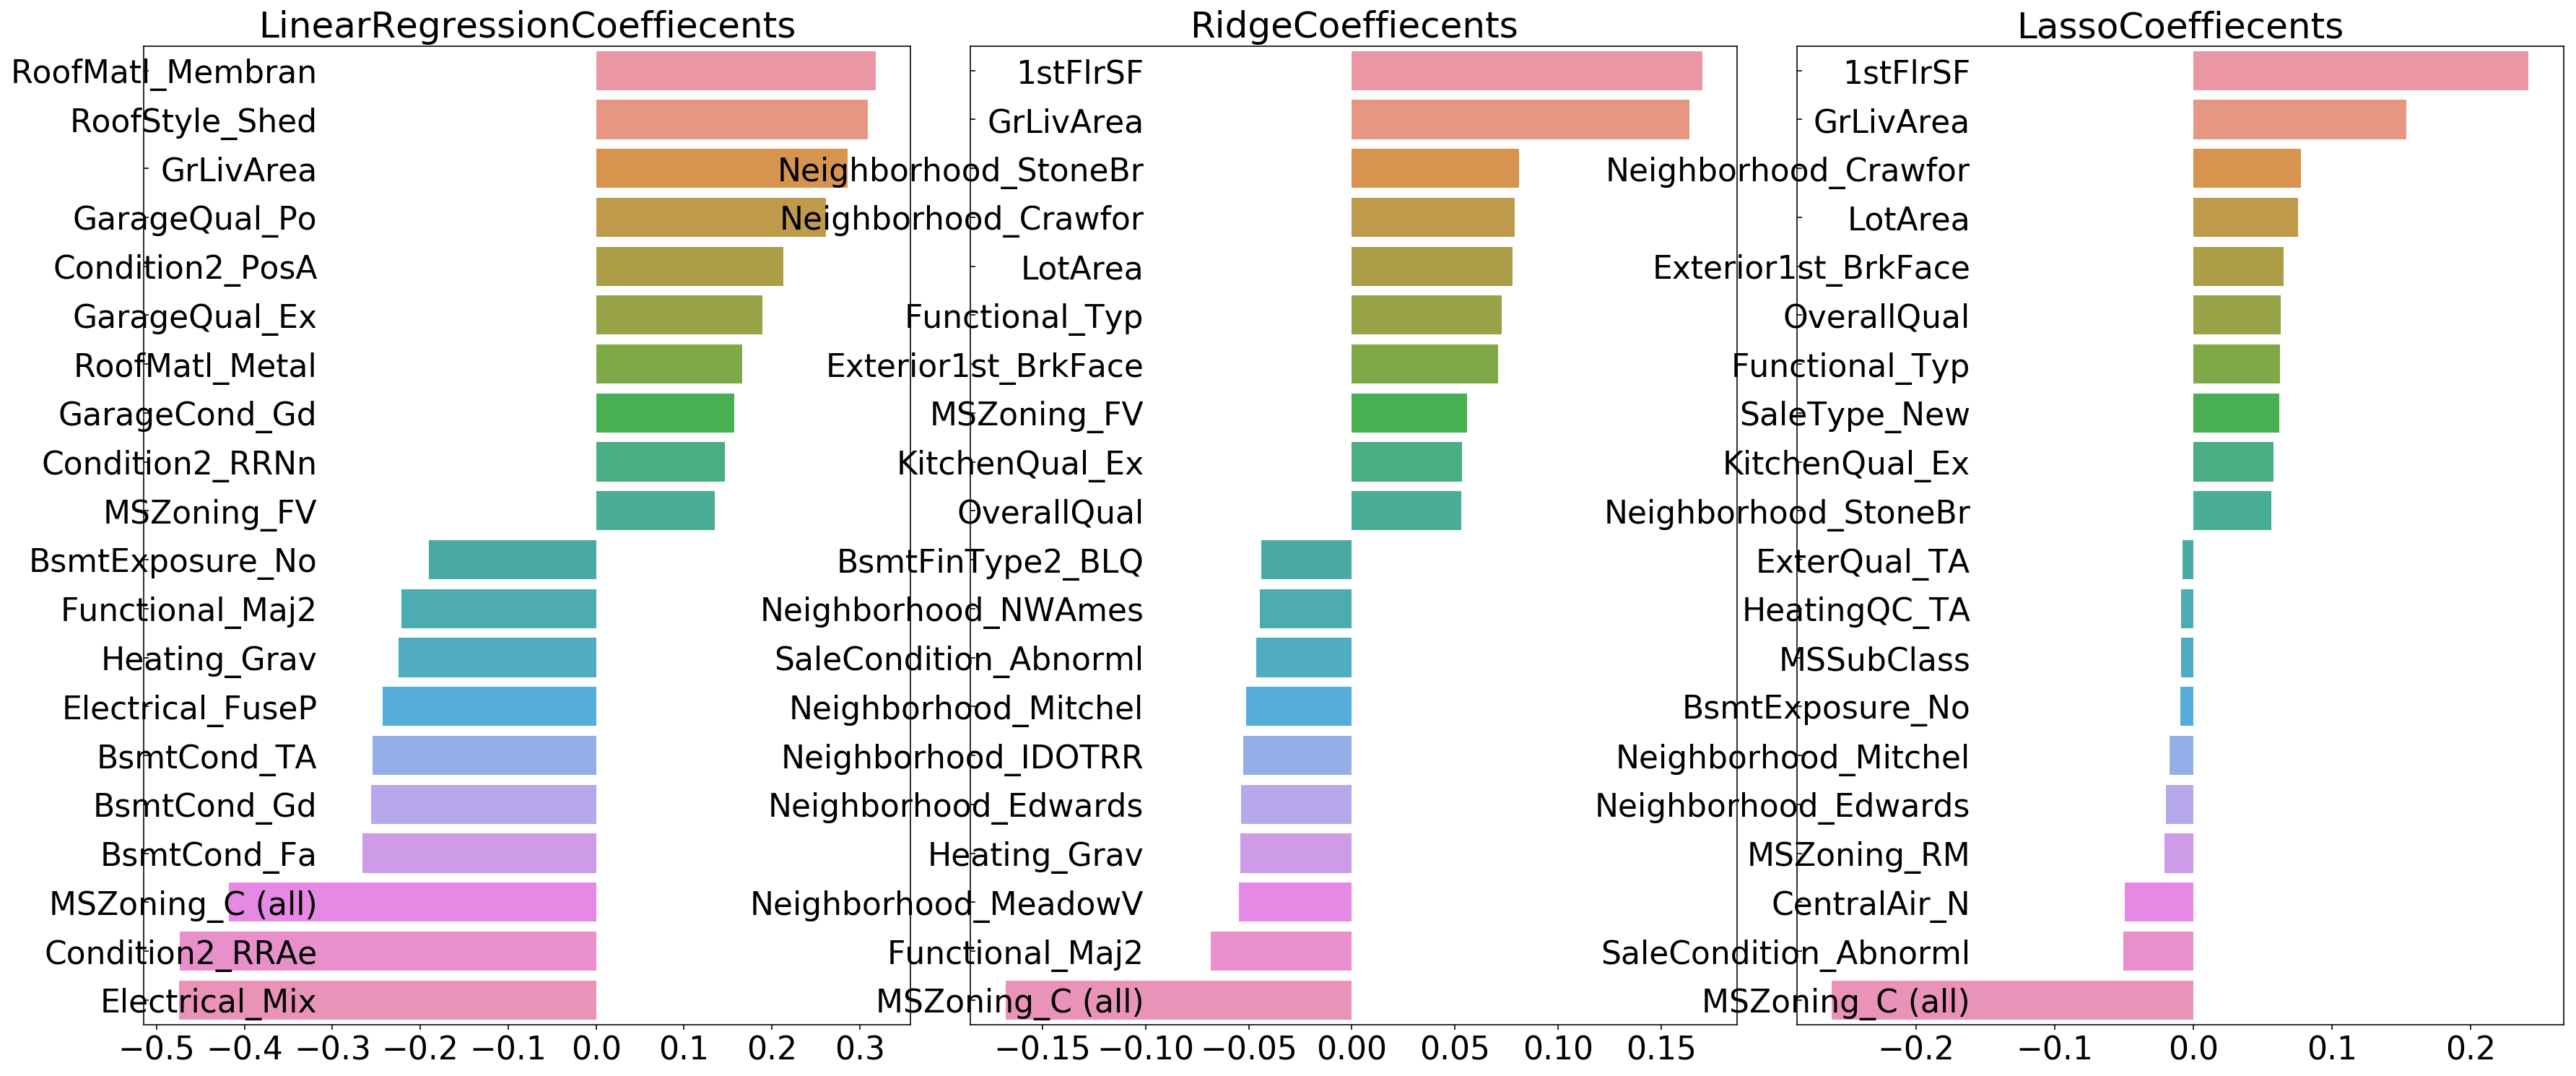

In [85]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [86]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1152, 최적 alpha:{'n_estimators': 1000}


In [87]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1172, 최적 alpha:{'n_estimators': 1000}


In [88]:
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()  
    for i_num, model in enumerate(models):
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

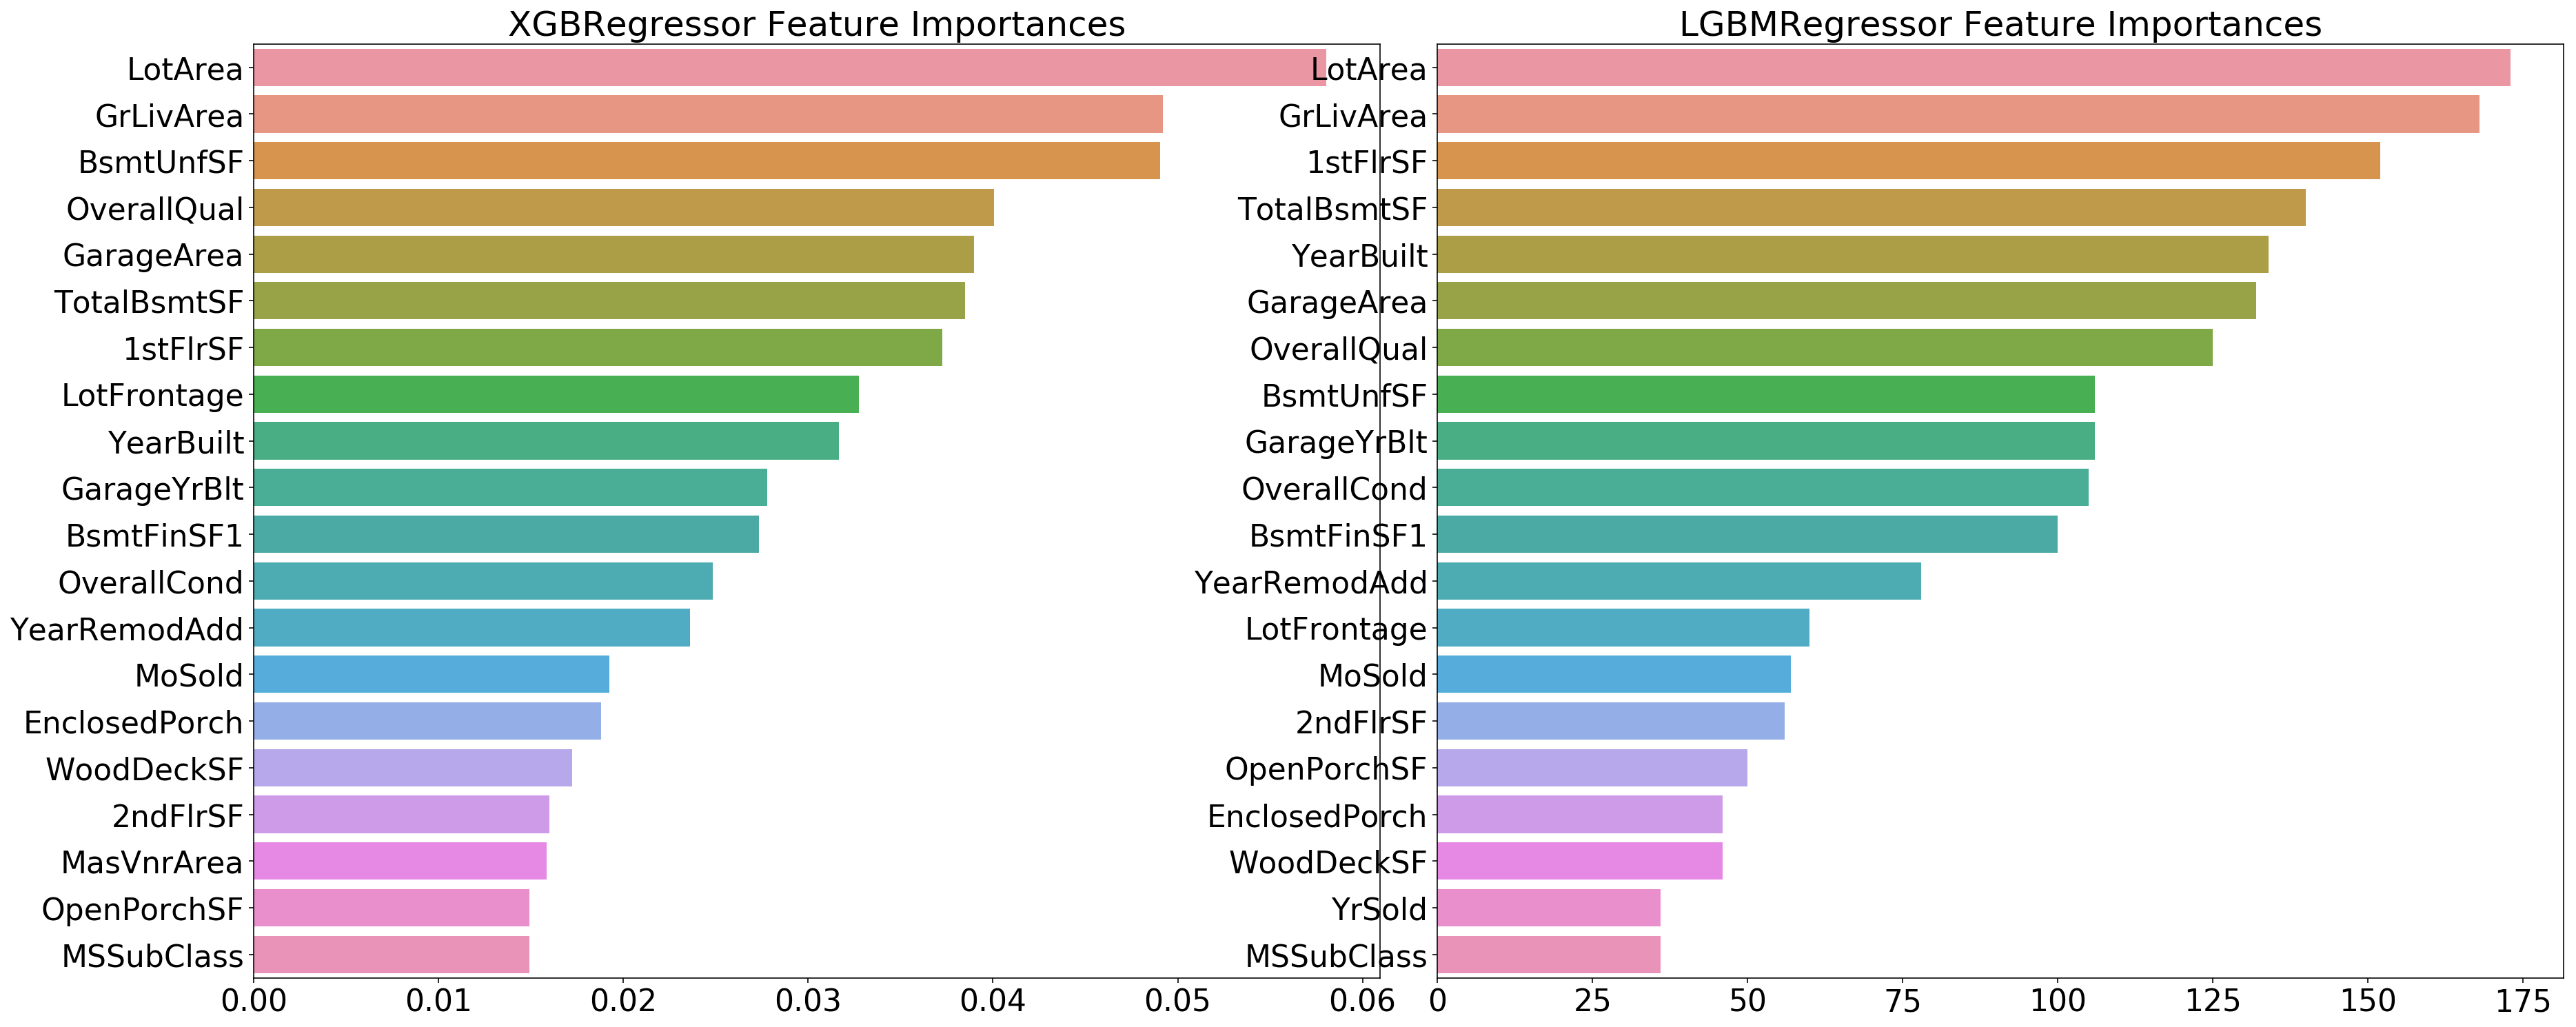

In [89]:
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

In [90]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

In [91]:
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)


ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)

In [92]:
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470506
Ridge 모델의 RMSE: 0.10345177546603244
Lasso 모델의 RMSE: 0.10024170460890028


In [93]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10052902892237098
XGBM 모델의 RMSE: 0.10669588503339805
LGBM 모델의 RMSE: 0.10128491650705558


In [94]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [95]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)

    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        model.fit(X_tr , y_tr)       
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred , test_pred_mean

In [96]:
x_train_n = x_train.values
x_test_n = x_test.values
y_train_n = y_train.values


ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, x_train_n, y_train_n, x_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, x_train_n, y_train_n, x_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, x_train_n, y_train_n, x_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, x_train_n, y_train_n, x_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [97]:
Stack_final_x_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_x_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)


meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_x_train, y_train)
final = meta_model_lasso.predict(Stack_final_x_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09749379255891868
